# 2D Geometric Tranformation

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [13]:
# Obtener una grilla para realizar las transformaciones

def get_grid(height, width, homogenous=False):
    coords = np.indices((height, width)).reshape(2, -1) 
    # Get indices of matrix (x, y)
    # [r1, r2, r3]
    # [c1, c2, c3]

    return np.vstack((coords, np.ones(coords.shape[1]))).astype(np.int32) if homogenous else coords
    # Get indices of matrix (x, y, 1)
    # [r1, r2, r3]
    # [c1, c2, c3]
    # [ 1,  1,  1]

In [14]:
# Imprime la imágen

def show_image(img):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(img)
    plt.show()

In [15]:
# Obtiene una matriz de transformación (o combinación de transformaciones)
# trasladar al centro -> rotar -> scalar/invertir -> volver a su posición

def get_transformed_matrix(angle, rot, tx, ty, sx, sy):
    R = np.array([
        [np.cos(angle), np.sin(angle), 0],
        [-np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])

    T = np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])

    if rot % 180 == 0:
        T2 = np.array([
            [1, 0, tx],
            [0, 1, ty],
            [0, 0, 1]
        ])
    else:
        T2 = np.array([
            [1, 0, ty],
            [0, 1, tx],
            [0, 0, 1]
        ])

    S = np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0, 0, 1]
    ])

    A = T2@R@S@np.linalg.inv(T)
    return A

In [16]:
# obtener una imágen, rotado (rot) y con reflexión (sx eje 'x'), (sy eje 'y')

def get_based_on_rotation(img, rot, sx, sy):
    height, width = img.shape[:2]
    tx, ty = np.array((height//2, width//2))

    angle = np.radians(rot)
    A = get_transformed_matrix(angle, rot, tx, ty, sx, sy)
    
    # Grid to represent the image coordinates I (x, y)
    coords = get_grid(height, width, True)
    x1, y1 = coords[0], coords[1]

    # Apply transformation and nearest neighbor interpolation
    warp_coords = np.round(A @ coords).astype(np.int32)
    x2, y2 = warp_coords[0, :], warp_coords[1, :]

    # Get pixels within image
    if rot % 180 == 0:
        indices = np.where((x2 >= 0) & (x2 < height) &
                        (y2 >= 0) & (y2 < width))
    else:
        indices = np.where((x2 >= 0) & (x2 < width) &
                        (y2 >= 0) & (y2 < height))

    xpix2, ypix2 = x2[indices], y2[indices]
    xpix1, ypix1 = x1[indices], y1[indices]

    # Copy the values to new image I'(x, y)
    if rot % 180 == 0:
        canvas = np.zeros((height, width, 3))
    else:
        canvas = np.zeros((width, height, 3))
        
    canvas = canvas.astype(int)
    canvas[xpix2, ypix2] = img[xpix1, ypix1]
    #show_image(canvas)
    return canvas

In [17]:
# Imprimir el area formado por los puntos con o sin la imágen

def print_points_image(source, target, title='', img=None):
    fig, ax = plt.subplots(figsize=(8,6))

    if img is not None:
        ax.imshow(img)
    
    x, y = source[1], source[0]
    #ax.scatter(x, y, label='source', marker='o', alpha=0.8, s=200, c='r')
    
    x, y = target[1], target[0]
    #ax.scatter(x, y, label='target', marker='x', alpha=0.8, s=300, c='y')
    ax.fill(x, y, label='target', alpha=0.5, c='r')

    
    ax.legend()
    # ax.set_xlim(-10, 650)
    # ax.set_ylim(-10, 550)
    ax.invert_yaxis()
    ax.grid(True)
    ax.set_title(title)
    plt.show()

In [18]:
# Imprimir el area formado por los puntos con o sin la imágen

def print_points_image_v2(areas, title='', img=None):
    fig, ax = plt.subplots(figsize=(8,6))

    if img is not None:
        ax.imshow(img)
    
    for area in areas:
        x, y = area[1], area[0]
        #ax.scatter(x, y, label='target', marker='x', alpha=0.8, s=300, c='y')
        ax.fill(x, y, label='target', alpha=0.5, c='r')

    
    ax.legend()
    # ax.set_xlim(-10, 650)
    # ax.set_ylim(-10, 550)
    ax.invert_yaxis()
    ax.grid(True)
    ax.set_title(title)
    plt.show()

In [19]:
# Escribir en un archivo las nuevas coordenadas

def write_points(path, coords):
    with open(path, 'w') as f:
        for i in range(len(coords[0])):
            x = coords[0][i]
            y = coords[1][i]
            f.write(str(x)+','+str(y)+'\n')
    f.close()

In [20]:
# Transformar los puntos + transformar la imágen 
# resultado puntos (wrap_coords)
# resultado imágen (auximg)

def transformed_pts(img, pts, name):
    height, width = img.shape[:2]
    tx, ty = np.array((height//2, width//2))
    rotations = [0, 90, 180, 270]

    for rot in rotations:
        angle = np.radians(rot)
        A = get_transformed_matrix(angle, rot, tx, ty, sx=1, sy=1)
        warp_coords = np.round(A@pts).astype(np.int32)
        #print(pts)
        #print('rot'+str(rot), ':', warp_coords)
        auximg = get_based_on_rotation(img, rot, sx=1, sy=1)
        cv2.imwrite('./output/'+name+'_rot'+str(rot)+'.png', auximg)
        print_points_image(pts, warp_coords, 'rot'+str(rot), auximg)
        write_points('./output/'+name+'_rot'+str(rot)+'.txt', warp_coords)
    
    # Changint the source (just for plot)
    A = get_transformed_matrix(0, 0, tx, ty, sx=-1, sy=1)
    auxpts = np.round(A@pts).astype(np.int32)

    for rot in rotations:
        angle = np.radians(rot)
        A = get_transformed_matrix(angle, rot, tx, ty, sx=-1, sy=1)
        warp_coords = np.round(A@pts).astype(np.int32)
        #print(auxpts)
        #print('reflex+rot'+str(rot), ':', warp_coords)
        auximg = get_based_on_rotation(img, rot, sx=-1, sy=1)
        cv2.imwrite('./output/'+name+'_reflex+rot'+str(rot)+'.png', auximg)
        print_points_image(auxpts, warp_coords, 'reflex+rot'+str(rot), auximg)
        write_points('./output/'+name+'_reflex+rot'+str(rot)+'.txt', warp_coords)

In [21]:
# Main
# Mostrar la imágen original y proceder con la transformación

with os.scandir('test/') as entries:
    for entry in entries:
        filename = entry.name
        if filename[-4:] == '.txt':
            name = filename[:-4]
            image_path = './test/{}.jpg'.format(name)

            print(image_path)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            height, width = image.shape

            fig, ax = plt.subplots(figsize=(8, 6))
            ax.imshow(image)

            pts = [[], [], []]

            with open('./test/{}.txt'.format(name), 'r') as f:
                line = f.readline()
                while line != '': 
                    line = line.strip()
                    line = list(line.split())
                    line = [float(val) for val in line]
                    x1 = line[1]*width
                    y1 = line[2]*height
                    x2 = line[3]*width
                    y2 = line[4]*height
                    ax.fill([x1, x1, x2, x2], [y1, y2, y2, y1], label='origin', alpha=0.5, c='b')

                    # pts[0].append(line[0]) 
                    # pts[1].append(line[1])
                    # pts[2].append(1) 
                    line = f.readline()
                f.close()

            print(pts)
            #ax.scatter(pts[1], pts[0], label='origin', marker='o', alpha=0.8, s=100, c='r')
            

            #ax.set_xlim(-10, 650)
            ax.set_ylim(0, image.shape[0])
            ax.invert_yaxis()
            plt.show()
            #transformed_pts(image, pts, name)

./test/20220919_144201_jpg.rf.a5fcb664899027aa2c4f1ddba43848f4.jpg


ValueError: too many values to unpack (expected 2)

./output/instagram_reflex+rot0.png
[[412, 412, 312, 312], [100, 200, 100, 200], [1, 1, 1, 1]]


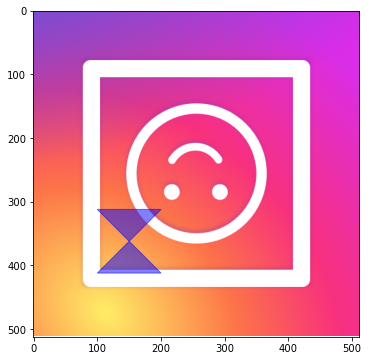

./output/instagram_reflex+rot180.png
[[100, 100, 200, 200], [412, 312, 412, 312], [1, 1, 1, 1]]


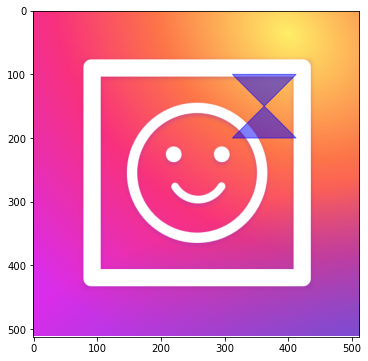

./output/instagram_reflex+rot270.png
[[412, 312, 412, 312], [412, 412, 312, 312], [1, 1, 1, 1]]


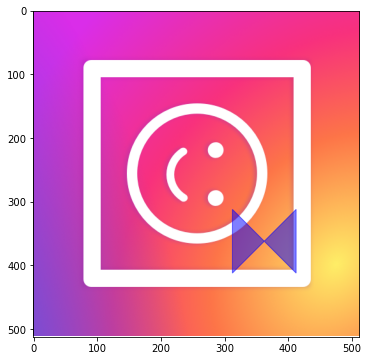

./output/instagram_reflex+rot90.png
[[100, 200, 100, 200], [100, 100, 200, 200], [1, 1, 1, 1]]


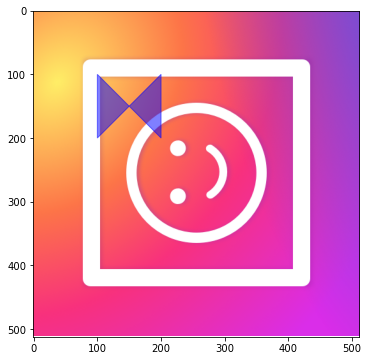

./output/instagram_rot0.png
[[100, 100, 200, 200], [100, 200, 100, 200], [1, 1, 1, 1]]


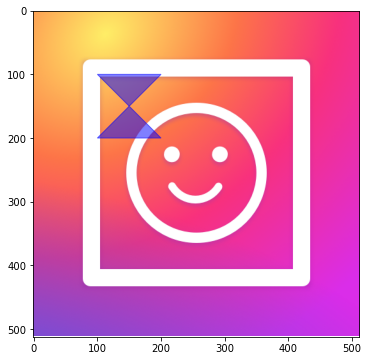

./output/instagram_rot180.png
[[412, 412, 312, 312], [412, 312, 412, 312], [1, 1, 1, 1]]


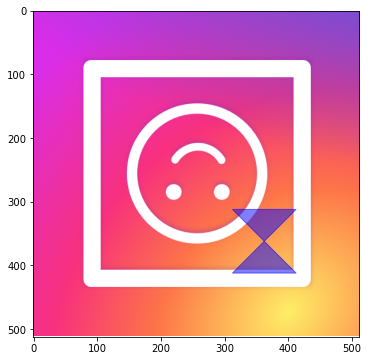

./output/instagram_rot270.png
[[412, 312, 412, 312], [100, 100, 200, 200], [1, 1, 1, 1]]


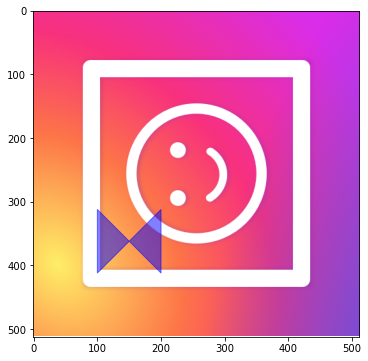

./output/instagram_rot90.png
[[100, 200, 100, 200], [412, 412, 312, 312], [1, 1, 1, 1]]


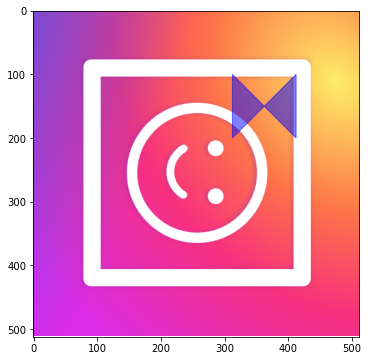

./output/left_reflex+rot0.png
[[320, 350, 340, 270, 215], [50, 20, 30, 200, 220], [1, 1, 1, 1, 1]]


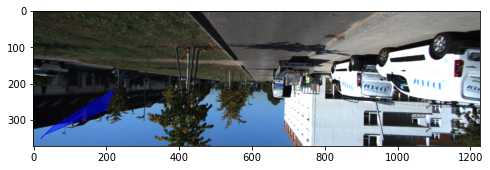

./output/left_reflex+rot180.png
[[50, 20, 30, 100, 155], [1176, 1206, 1196, 1026, 1006], [1, 1, 1, 1, 1]]


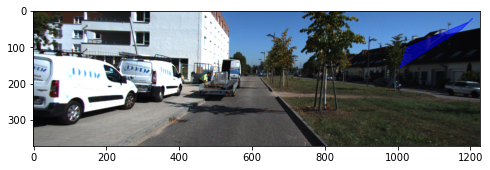

./output/left_reflex+rot270.png
[[1176, 1206, 1196, 1026, 1006], [320, 350, 340, 270, 215], [1, 1, 1, 1, 1]]


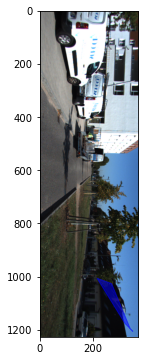

./output/left_reflex+rot90.png
[[50, 20, 30, 200, 220], [50, 20, 30, 100, 155], [1, 1, 1, 1, 1]]


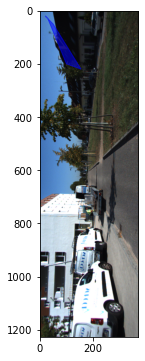

./output/left_rot0.png
[[50, 20, 30, 100, 155], [50, 20, 30, 200, 220], [1, 1, 1, 1, 1]]


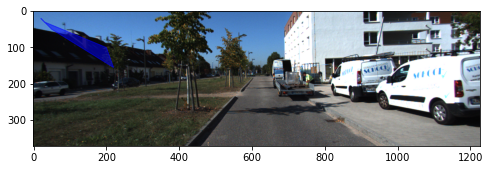

./output/left_rot180.png
[[320, 350, 340, 270, 215], [1176, 1206, 1196, 1026, 1006], [1, 1, 1, 1, 1]]


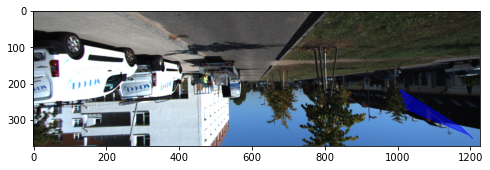

./output/left_rot270.png
[[1176, 1206, 1196, 1026, 1006], [50, 20, 30, 100, 155], [1, 1, 1, 1, 1]]


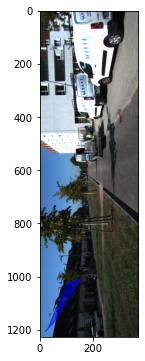

./output/left_rot90.png
[[50, 20, 30, 200, 220], [320, 350, 340, 270, 215], [1, 1, 1, 1, 1]]


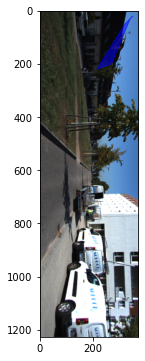

./output/reflex+rot0.png


TypeError: Image data of dtype object cannot be converted to float

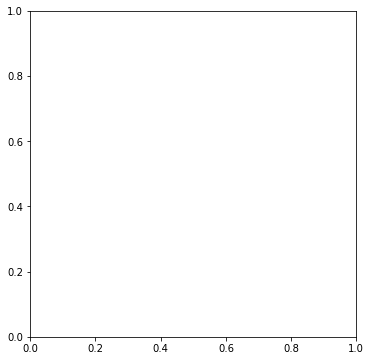

In [ ]:
# Prueba para leer los puntos y la imágen, luego imprimirlos

with os.scandir('output/') as entries:
    for entry in entries:
        filename = entry.name
        if filename[-4:] == '.txt':
            name = filename[:-4]
            image_path = './output/{}.png'.format(name)

            print(image_path)
            image = cv2.imread(image_path)
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.imshow(image)

            pts = [[], [], []]

            with open('./output/{}.txt'.format(name), 'r') as f:
                line = f.readline()
                while line != '': 
                    line = line.strip()
                    line = list(line.split(','))
                    line = [int(val) for val in line]
                    pts[0].append(line[0]) 
                    pts[1].append(line[1])
                    pts[2].append(1) 
                    line = f.readline()
                f.close()

            print(pts)
            #ax.scatter(pts[1], pts[0], label='origin', marker='o', alpha=0.8, s=100, c='r')
            ax.fill(pts[1], pts[0], label='origin', alpha=0.5, c='b')

            #ax.set_xlim(-10, 650)
            ax.set_ylim(0, image.shape[0])
            ax.invert_yaxis()
            plt.show()